In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df_novo = pd.read_csv('data/train_sales.csv', index_col='id',parse_dates=['date'])

In [3]:
df_novo

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,2013-01-01,1,BABY CARE,0.000,0
2,2013-01-01,1,BEAUTY,0.000,0
3,2013-01-01,1,BEVERAGES,0.000,0
4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.133,0
3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,2017-08-15,9,PRODUCE,2419.729,148


In [4]:
df_1 = df_novo.loc[df_novo['store_nbr'] == 1]
df_1 = df_1.drop(['store_nbr', 'onpromotion'], axis=1)
df_1 = df_1.rename(columns={'date':'ds','sales':'y','family':'unique_id'})
df_1

,ds,unique_id,y
id,,,
0,2013-01-01,AUTOMOTIVE,0.000000
1,2013-01-01,BABY CARE,0.000000
2,2013-01-01,BEAUTY,0.000000
3,2013-01-01,BEVERAGES,0.000000
4,2013-01-01,BOOKS,0.000000
...,...,...,...
2999134,2017-08-15,POULTRY,234.892000
2999135,2017-08-15,PREPARED FOODS,42.822998
2999136,2017-08-15,PRODUCE,2240.230000


In [5]:
treino = df_1.loc[df_1['ds'] < '2014-01-01']
valid = df_1.loc[(df_1['ds'] >= '2014-01-01') & (df_1['ds'] < '2014-04-01')]
h = valid['ds'].nunique()

In [6]:
h

90

In [7]:
def wmape(y_true, y_pred):
    return np.abs(y_true-y_pred).sum() / np.abs(y_true).sum()

In [8]:
from statsforecast import StatsForecast
from statsforecast.models import Naive

C:\Users\mvsam\Anaconda3\lib\site-packages\statsforecast\core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [9]:
model = StatsForecast(models=[Naive()],freq='D',n_jobs=-1)
model.fit(treino)

forecast_df = model.predict(h=h, level=[90])
forecast_df = forecast_df.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

wmape = wmape(forecast_df['y'].values, forecast_df['Naive'].values)

print('WMAPE: ', wmape)

WMAPE:  0.574998521469236


C:\Users\mvsam\Anaconda3\lib\site-packages\statsforecast\core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


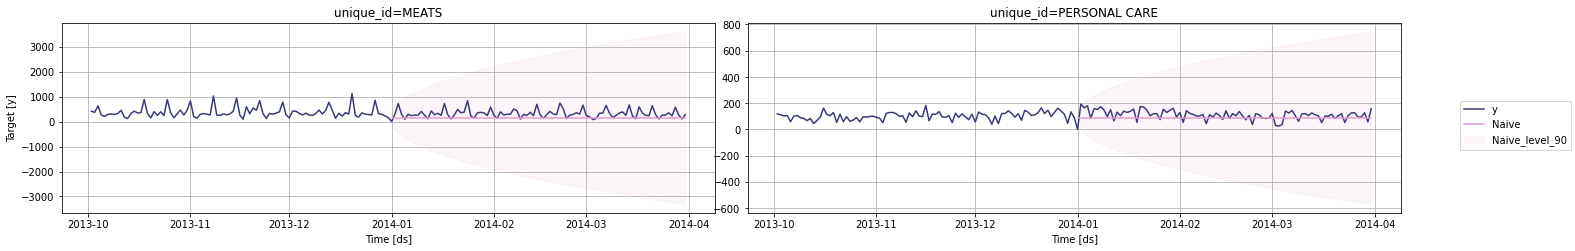

In [16]:
model.plot(treino, forecast_df, level=[90], unique_ids=['MEATS', 'PERSONAL CARE'],engine='matplotlib', max_insample_length=90)